<a href="https://colab.research.google.com/github/David-Carballo/2023w-project-pose/blob/main/YogaPostureCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Descarga e instala la libreria del openpose



In [ ]:
!pip install git+https://github.com/prasunroy/openpose-pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/prasunroy/openpose-pytorch.git to /tmp/pip-req-build-a0gxfrok
  Running command git clone --filter=blob:none --quiet https://github.com/prasunroy/openpose-pytorch.git /tmp/pip-req-build-a0gxfrok
  Resolved https://github.com/prasunroy/openpose-pytorch.git to commit 8955ef1d220d5dc43dd5e573a49e323393ae5446
  Preparing metadata (setup.py) ... done
  Created wheel for openpose-pytorch: filename=openpose_pytorch-0.1.0-py3-none-any.whl size=10270 sha256=bb101be0adf89673e6a3469e346046465f83271c1cb19ef3bc194aafb3e2c570
  Stored in directory: /tmp/pip-ephem-wheel-cache-c__o62x9/wheels/38/fc/56/e5c574e56aedc8f970ef5ad594021411fc25e11375bbe25257
Successfully built openpose-pytorch


Instancia los modulos necesarios

In [ ]:
import sys
import os
import cv2
from openpose.body.estimator import BodyPoseEstimator
from openpose.utils import draw_body_connections, draw_keypoints
from google.colab.patches import cv2_imshow 
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.utils import list_files
from torchvision.datasets.folder import pil_loader
from torchvision.utils import make_grid
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from PIL import Image
import os
import zipfile
import albumentations as A
import cv2
import random
from torchvision.transforms import ToPILImage

device = 'cuda'

MOntar el drive donde esta el dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Descargar y descomprimir el dataset. La ruta al dataset tiene que ser consultada

In [ ]:
# nombre del archivo zip
zip_file = '/content/drive/MyDrive/YogaPostureDataset.zip'
# ruta donde se descomprimirá el archivo
extract_to = '/content/descomprimido'
# descomprimir el archivo
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Split dataset

In [ ]:
import os
import shutil
import random

def split_dataset(source, train, validation, test, train_ratio=0.6, validation_ratio=0.2):
    classes = [d for d in os.listdir(source) if os.path.isdir(os.path.join(source, d))]
    
    if not os.path.exists(train):
        os.makedirs(train)
    if not os.path.exists(validation):
        os.makedirs(validation)
    if not os.path.exists(test):
        os.makedirs(test)

    for class_name in classes:
        class_path = os.path.join(source, class_name)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(images)

        train_size = int(len(images) * train_ratio)
        validation_size = int(len(images) * validation_ratio)

        train_path = os.path.join(train, class_name)
        validation_path = os.path.join(validation, class_name)
        test_path = os.path.join(test, class_name)

        if not os.path.exists(train_path):
            os.makedirs(train_path)
        if not os.path.exists(validation_path):
            os.makedirs(validation_path)
        if not os.path.exists(test_path):
            os.makedirs(test_path)

        for i, image in enumerate(images):
            src_path = os.path.join(class_path, image)
            if i < train_size:
                dest_path = os.path.join(train_path, image)
            elif i < train_size + validation_size:
                dest_path = os.path.join(validation_path, image)
            else:
                dest_path = os.path.join(test_path, image)

            shutil.copyfile(src_path, dest_path)

source_dir = '/content/descomprimido'
train_dir = '/content/dataset/train'
validation_dir = '/content/dataset/validation'
test_dir = '/content/dataset/test'

# Puedes ajustar los ratios aquí
train_ratio = 0.6
validation_ratio = 0.2

split_dataset(source_dir, train_dir, validation_dir, test_dir, train_ratio, validation_ratio)

In [ ]:
estimator = BodyPoseEstimator(pretrained=True)
# directorios de carpetas
train = '/content/dataset/train'
val = '/content/dataset/validation'
test = '/content/dataset/test'
# lista de directorios
directories = [train, val, test]
# recorre cada directorio
cnt = 0
for directory in directories:

    # recorre cada subcarpeta
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        # recorre cada imagen en la subcarpeta
        for filename in os.listdir(subdir_path):
          try:
            print(filename)
            file_path = os.path.join(subdir_path, filename)
            # lee la imagen
            img = cv2.imread(file_path)
            # cambia el color a negro
            keypoints = estimator(img)
            skeleton = draw_body_connections(img, keypoints, thickness=4, alpha=0.7)
            skeleton = draw_keypoints(skeleton, keypoints, radius=5, alpha=0.8)
            skeleton_black = draw_body_connections(img*0, keypoints, thickness=4, alpha=0.7)
            skeleton_black = draw_keypoints(skeleton_black, keypoints, radius=5, alpha=0.8)
            # cv2_imshow(image_dst)
            # guarda la imagen modificada
            modified_filename = os.path.splitext(filename)[0] + ".jpg"
            modified_path = os.path.join(subdir_path, modified_filename)
            modified_path = modified_path.replace("dataset", "preprocessed")
            subdir_path_preprocessed = subdir_path.replace("dataset", "preprocessed")
            if not os.path.exists(subdir_path_preprocessed):
              os.makedirs(subdir_path_preprocessed)
            print("Imagen creada: ", modified_path)
            # modified_path = os.path.join(subdir_path, modified_filename)
            cv2.imwrite(modified_path, skeleton)
            # modified_filename = os.path.splitext(filename)[0] + "_skeleton_black.jpg"
            # modified_path = os.path.join(subdir_path, modified_filename)
            # cv2.imwrite(modified_path, skeleton_black)
            cnt += 1
            print("Imagen numero ", cnt)
          except Exception as error:
            print("Ha habido un error en la imagen, probablemente sea un archivo no valido")
            print(error)

Downloading: "https://www.dropbox.com/s/mun9eh2509pw32n/openpose_body_coco_pose_iter_440000.pth?dl=1" to /root/.cache/torch/checkpoints/openpose_body_coco_pose_iter_440000.pth


100%|██████████| 200M/200M [00:01<00:00, 110MB/s]


File35.png
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File35.jpg
Imagen numero  1
File30.png
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File30.jpg
Imagen numero  2
File34.png
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File34.jpg
Imagen numero  3
File47.jpeg
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File47.jpg
Imagen numero  4
File25.png
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File25.jpg
Imagen numero  5
File18.png
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File18.jpg
Imagen numero  6
File10.png
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File10.jpg
Imagen numero  7
File41.png
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File41.jpg
Imagen numero  8
File8.png
Imagen creada:  /content/preprocessed/train/Eka Pada Rajakapotasana/File8.jpg
Imagen numero  9
File16.png
Imagen creada:  /content/pr

/usr/local/lib/python3.9/dist-packages/openpose/body/estimator.py:210: RuntimeWarning: invalid value encountered in true_divide
  v = np.divide(v, n)
/usr/local/lib/python3.9/dist-packages/openpose/body/estimator.py:217: RuntimeWarning: divide by zero encountered in double_scalars
  score_with_dist_prior = sum(score_midpoints) / len(score_midpoints) + min(0.5 * image.shape[0] / n - 1, 0)


Streaming output truncated to the last 5000 lines.
Imagen creada:  /content/preprocessed/train/Uttanasana/File43.jpg
Imagen numero  1091
File49.png
Imagen creada:  /content/preprocessed/train/Uttanasana/File49.jpg
Imagen numero  1092
File28.jpeg
Imagen creada:  /content/preprocessed/train/Uttanasana/File28.jpg
Imagen numero  1093
File46.png
Imagen creada:  /content/preprocessed/train/Uttanasana/File46.jpg
Imagen numero  1094
File45.png
Imagen creada:  /content/preprocessed/train/Uttanasana/File45.jpg
Imagen numero  1095
File19.png
Imagen creada:  /content/preprocessed/train/Uttanasana/File19.jpg
Imagen numero  1096
File40.png
Imagen creada:  /content/preprocessed/train/Uttanasana/File40.jpg
Imagen numero  1097
File60.png
Imagen creada:  /content/preprocessed/train/Uttanasana/File60.jpg
Imagen numero  1098
File33.png
Imagen creada:  /content/preprocessed/train/Uttanasana/File33.jpg
Imagen numero  1099
File12.png
Imagen creada:  /content/preprocessed/train/Uttanasana/File12.jpg
Imagen nu

In [ ]:
train_dir = '/content/preprocessed/train'
val_dir = '/content/preprocessed/validation'
test_dir = '/content/preprocessed/test'

Marc's Part

In [ ]:
class YogaDataset(Dataset):
    def __init__(self, data_dir, transforms = False):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        self.labels_num = []
        self.eps = 0.75
        self.transforms = transforms

        label_map = {}
        label_counter = 0

        for subdir in os.listdir(data_dir):
            subdir_path = os.path.join(data_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    file_path = os.path.join(subdir_path, file)
                    if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                        self.images.append(file_path)
                        label = subdir
                        if label not in label_map:
                            label_map[label] = label_counter
                            label_counter += 1
                        # Convert label to numerical ID and store it in self.labels_num
                        label_num = label_map[label]
                        self.labels.append(label)
                        self.labels_num.append(label_num)

    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path).convert('RGB') #CHECK
        if self.transforms == True:
            if random.random() < self.eps:
                img = self.data_augmentation(img=np.array(img))['image']
        tensor_img = transforms.ToTensor()(img)
        tensor_img = self.image_transform(tensor_img)
        label_num = self.labels_num[index]
        return tensor_img, label_num
    
    def image_transform(self, tensor):
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        resize = transforms.Resize(224)
        #Check if image size ratio is 1:1
        if tensor.shape[1] != tensor.shape[2]:
            #Calculate difference between X and Y axis
            diff = tensor.shape[1] - tensor.shape[2]
            #Check what dimension needs to be padded either the X (dimension 1 of the tensor, right), or the Y (dimension 3, bottom)
            if diff > 0:     
                tensor = F.pad(input=tensor, pad=(0, abs(diff), 0, 0), mode='constant', value=0) #pad(left, right, top, bottom)
            else:
                tensor = F.pad(input=tensor, pad=(0, 0, 0, abs(diff)), mode='constant', value=0)
        tensor = resize(tensor)
        tensor = tensor.reshape(3, 224, 224)
        return tensor

    def data_augmentation(self, img):
        da_transforms = A.Compose([
        A.HorizontalFlip(p = 0.5),
        A.GaussianBlur(p = 0.5),
        A.HueSaturationValue(p = 0.5),
        A.ColorJitter(p = 0.5),
        ])

        # apply data augmentation transforms
        img = da_transforms(image=np.array(img))['image']
        
        return {'image': img}


    def __len__(self):
        return len(self.images)

47 clases

In [ ]:
train_dataset = YogaDataset(train_dir, transforms = True)
test_dataset = YogaDataset(test_dir)
val_dataset = YogaDataset(val_dir)
print('Number of images', len(train_dataset))
print(train_dataset[1626])

Number of images 1631
(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.9997, 0.9986, 0.9952],
         [1.0000, 1.0000, 1.0000,  ..., 0.9964, 0.9964, 0.9964],
         [1.0000, 1.0000, 1.0000,  ..., 0.9780, 0.9586, 0.9546],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9975, 0.9975, 0.9975],
         [1.0000, 1.0000, 1.0000,  ..., 0.9993, 0.9996, 0.9991],
         [1.0000, 1.0000, 1.0000,  ..., 0.9612, 0.9316, 0.9248],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9950, 0.9950, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9983, 0.9987, 0.9994],
         [1.0000, 1.0000, 1.0000,  

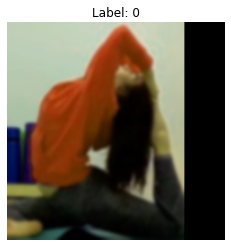

In [ ]:
image, label = train_dataset[0]

# convert the tensor image to a PIL Image
to_pil = ToPILImage()
pil_image = to_pil(image)

# plot the image and show its corresponding label
plt.imshow(pil_image)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [ ]:
#for image, label in train_dataset:
#shape = torchvision.transforms.functional.get_image_size(image)
#print (shape)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print(len(train_loader))

51


In [ ]:
model = torchvision.models.mobilenet_v3_small(weights = 'DEFAULT')
#Substitution of the model's last layer so it predicts between the 47 classes of the Dataset instead of the 1000 of Imagenet
in_features = model.classifier[0].in_features
model.classifier[0] = nn.Linear(in_features, 50)
model.classifier[-1] = nn.Linear(50, 47)
model.classifier[2] = nn.Dropout(0.3, inplace = True)

#Dropout 0.3/0.4
#Freeze all the layers except the final Linear

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[-1].parameters():
    param.requires_grad = True

model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


  0%|          | 0.00/9.83M [00:00<?, ?B/s]

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-3, weight_decay = 0.001)

In [ ]:
def train(model, train_loader, criterion, optimizer, device, num_epochs):
  
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []


    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print statistics every 10 batches
            if i % 10 == 9:
                print('[Epoch %d, Batch %d] Loss: %.3f, Accuracy: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10, 100 * correct / total))
                running_loss = 0.0
                correct = 0
                total = 0

    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)
    plt.plot(train_acc_list)
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

    print('Finished Training')

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
  
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Print statistics every 10 batches
            if i % 10 == 9:
                print('[Epoch %d, Batch %d] Loss: %.3f, Accuracy: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10, 100 * correct / total))
                running_loss = 0.0
                correct = 0
                total = 0

        # Calculate training accuracy
        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)

        # Evaluate on validation set
        val_acc = validate(model, val_loader, criterion, device, val_acc_list)

        # Append training and validation accuracy to lists
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

    # Plot accuracy graphs
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print('Finished Training')

In [ ]:
def train(model, train_loader, criterion, optimizer, device, num_epochs):
  
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []


    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate accuracy and loss after each epoch
        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)
        train_loss = running_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Run validation loop after each epoch
        val_acc = validate(model, val_loader, criterion, device, val_acc_list)
        val_acc_list.append(val_acc)

        print('[Epoch %d] Train Loss: %.3f, Train Accuracy: %.3f, Validation Accuracy: %.3f' %
              (epoch + 1, train_loss, train_acc, val_acc))

    # Plot accuracy for both train and validation loops
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    print('Finished Training')

In [ ]:
def train(model, train_loader, criterion, optimizer, device, num_epochs):
  
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Update train loss and accuracy once per epoch
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        
        # Run validation loop once per epoch and update val accuracy
        val_acc = validate(model, val_loader, criterion, device)
        val_acc_list.append(val_acc)

        print('[Epoch %d] Train Loss: %.3f, Train Acc: %.3f, Val Acc: %.3f' %
              (epoch + 1, train_loss, train_acc, val_acc))

    # Plot train and val accuracy once training is finished
    plt.plot(train_acc_list)
    plt.plot(val_acc_list)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Validation'])
    plt.show()

    print('Finished Training')




In [ ]:
def validate(model, val_loader, criterion, device, acc_list=None):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Print validation statistics
    print('Validation Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(val_loader), accuracy))

    # Append accuracy to list if provided
    if acc_list is not None:
        acc_list.append(accuracy)

    return accuracy

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    # Print validation statistics
    print('Validation Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(val_loader), accuracy))

    return accuracy

[Epoch 1, Batch 10] Loss: 3.864, Accuracy: 3.438
[Epoch 1, Batch 20] Loss: 3.844, Accuracy: 3.438
[Epoch 1, Batch 30] Loss: 3.831, Accuracy: 5.625
[Epoch 1, Batch 40] Loss: 3.825, Accuracy: 2.188
[Epoch 1, Batch 50] Loss: 3.823, Accuracy: 2.500
[Epoch 2, Batch 10] Loss: 3.803, Accuracy: 2.812
[Epoch 2, Batch 20] Loss: 3.797, Accuracy: 3.438
[Epoch 2, Batch 30] Loss: 3.792, Accuracy: 4.375
[Epoch 2, Batch 40] Loss: 3.780, Accuracy: 4.688
[Epoch 2, Batch 50] Loss: 3.782, Accuracy: 1.875
[Epoch 3, Batch 10] Loss: 3.769, Accuracy: 3.438
[Epoch 3, Batch 20] Loss: 3.743, Accuracy: 5.312
[Epoch 3, Batch 30] Loss: 3.737, Accuracy: 7.188
[Epoch 3, Batch 40] Loss: 3.741, Accuracy: 6.250
[Epoch 3, Batch 50] Loss: 3.739, Accuracy: 5.312
[Epoch 4, Batch 10] Loss: 3.714, Accuracy: 8.750
[Epoch 4, Batch 20] Loss: 3.714, Accuracy: 7.188
[Epoch 4, Batch 30] Loss: 3.721, Accuracy: 5.000
[Epoch 4, Batch 40] Loss: 3.720, Accuracy: 9.688
[Epoch 4, Batch 50] Loss: 3.697, Accuracy: 6.562
[Epoch 5, Batch 10] 

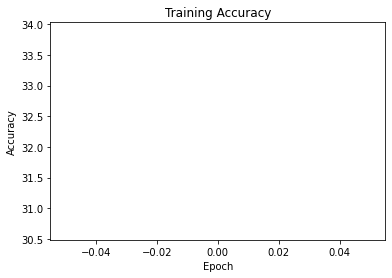

Finished Training


In [ ]:
num_epochs = 50
train(model, train_loader, criterion, optimizer, device, num_epochs)

In [ ]:
def validate(model, val_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print validation statistics
    print('Validation Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(val_loader), 100 * correct / total))

    return 100 * correct / total

In [ ]:
validate(model, val_loader, criterion, device)

In [ ]:
def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy on the test set: %d %%' % (accuracy))

In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()  # set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print test statistics
    print('Test Loss: %.3f, Accuracy: %.3f' %
          (running_loss / len(test_loader), 100 * correct / total))

    return 100 * correct / total

In [ ]:
test(model, test_loader, criterion, device)

Test Loss: 3.107, Accuracy: 31.040


31.040268456375838

# David's Part

Tendríamos que pegar aquí el código que has hecho para entrenar el modelo MLP que viene a continuación.

El dataset ya esta descargado en la anterior parte, la de marc, y el modelo ya está instalado tambien, así que vale con pegar la parte de inferencia, filtrado y escritura del csv

Declaración del mismo modelo de David sin entrenar, para cortar la ultima capa y obtener los features, y realizar la conexion de redes

In [ ]:
import math

#Given the points A,B and C, compute the angle formed by the vectors AB and BC
def compute_angle(ax,ay, bx,by, cx,cy):
    dot_product = (bx - ax) * (cx - bx) + (by - ay) * (cy - by)
    mag0 = math.sqrt((bx - ax)**2 + (by - ay)**2)
    mag1 = math.sqrt((cx - bx)**2 + (cy - by)**2)
    angle = math.acos(dot_product / (mag0 * mag1))

    return angle

#Given the keypoints of the pose, calculate its angle
def get_angles(keypoints):
    n = len(keypoints)
    output = torch.empty(n,12)
    
    i = 0
    for kps in keypoints:
        connections =  [(0,1,2), (1,2,3), (2,3,4), (0,1,5), (1,5,6), (5,6,7), (1,2,8), (2,8,9), (8,9,10), (1,5,11), (5,11,12), (11,12,13)]

        angles = []

        for a,b,c in connections:
            Ax = kps[a][0]
            Ay = kps[a][1]
            Bx = kps[b][0]
            By = kps[b][1]
            Cx = kps[c][0]
            Cy = kps[c][1]
            
            angle_deg = compute_angle(Ax, Ay, Bx, By, Cx, Cy)
            angles.append(angle_deg)
        output[i] = torch.FloatTensor(angles)
        i +=1
    output = torch.nan_to_num(output)
    return output

In [ ]:
# Load precomputed keypoints from file
load_keypoints = torch.load('keypoints')

In [ ]:
!rm 'data/Poses.json'

class AnglesDataset(Dataset):
    def __init__(self, data_dir, transforms=True, keypoints=None):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        #self.keypoints = keypoints
        self.transforms = transforms
        self.angles = get_angles(keypoints)

        for i, subdir in enumerate(sorted(os.listdir(data_dir))):
            subdir_path = os.path.join(data_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in sorted(os.listdir(subdir_path)):
                    file_path = os.path.join(subdir_path, file)
                    if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                        self.images.append(file_path)
                        self.labels.append(i)
        
    def __getitem__(self, index):
        ang = self.angles[index]
        
        #ang = self.angles[index]
        if self.transforms == True:
            if random.random() < 0.75:
                ang = self.add_noise(ang,90)

        #new_ang = get_angles2(ang)
        return ang, self.labels[index]

    def add_noise(self,angles, alpha):
        new_ang = angles.clone()
        n = random.uniform(-alpha,alpha) * math.pi / 180
        
        #new_ang = torch.add(angles, n)
        for i,a in enumerate(angles):
            if angles[i] > 0:
                new_ang[i] = max(0, angles[i] + n)
        return new_ang
    
    def __len__(self):
        return len(self.images)

In [ ]:
# Test Dataset class
angles_dataset = AnglesDataset('data', True, load_keypoints)

n_train = int(0.8 * len(yoga_dataset))
train_set, test_set = torch.utils.data.random_split(angles_dataset, [n_train, len(angles_dataset) - n_train])

n_train = int(0.8 * len(train_set))
train_set, val_set = torch.utils.data.random_split(train_set, [n_train, len(train_set) - n_train])

train_loader = DataLoader(dataset=train_set, batch_size=hparams['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=hparams['batch_size'], shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=hparams['batch_size'], shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.batch = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size*2, output_size)
        

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch(self.relu1(out))
        out = self.drop(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop(out)
        out = self.fc3(out)
        return out

In [ ]:
hparams = {
    'batch_size':64,
    'num_epochs':500,
    'test_batch_size':64,
    'hidden_size':32,
    'num_classes':47,
    'num_inputs':12,
    'learning_rate':0.001,
}
# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

mlp = MLP(hparams['num_inputs'], hparams['hidden_size'] ,hparams['num_classes'])
mlp.to(hparams['device'])

MLP(
  (fc1): Linear(in_features=18, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=47, bias=True)
)

Cortamos últimas capas de ambos modelos

In [ ]:
mobilenet_cropped = nn.Sequential(*(list(model.children())[:-1]))
mlp_cropped = nn.Sequential(*(list(mlp.children())[:-1]))

Declaramos la red que combina ambos modelos, el de imagen y el de csv

In [ ]:
class FusionMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FusionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

fusion_mlp = FusionMLP(input_size=47*2, hidden_size=128, output_size=47)

Creamos una 4ta red, que coge las 2 redes iniciales, y las deja conectadas a la red final de fusión. SIn esta red, las 3 redes que hemos creado estarían flotando, sin conectarse

In [ ]:
class FusionModel(nn.Module):
    def __init__(self, mobilenet, mlp_model, fusion_mlp):
        super(FusionModel, self).__init__()
        self.mobilenet = mobilenet
        self.mlp_model = mlp_model
        self.fusion_mlp = fusion_mlp

    def forward(self, image_input, csv_input):
        x1 = self.mobilenet(image_input)
        x1 = x1.view(x1.size(0), -1)  # Aplanar la salida del modelo Mobilenet
        
        x2 = self.mlp_model(csv_input)
        
        x = torch.cat((x1, x2), dim=1)  # Concatenar las salidas
        x = self.fusion_mlp(x)
        return x

fusion_model = FusionModel(mobilenet_cropped, mlp_cropped, fusion_mlp)

Ahora entrenamos el modelo fusionado. Hay que entender, que va a recibir simultaneamente datos de 2 datasets, uno de iamgenes, y el del csv, así que tenemos que programar una clase, que no solo cargue datos simultaneamente de ambos, sino que ademas siga permitiendo dividir el dataset en train, validation y test

In [ ]:
class CombinedYogaDataset(Dataset):
    def __init__(self, data_dir, csv_path, indices=None, transforms=False):
        self.data_dir = data_dir
        self.images = []
        self.labels = []
        self.labels_num = []
        self.angles = self.load_angles(csv_path)
        self.transforms = transforms

        label_map = {}
        label_counter = 0

        for subdir in os.listdir(data_dir):
            subdir_path = os.path.join(data_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    file_path = os.path.join(subdir_path, file)
                    if file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.png'):
                        self.images.append(file_path)
                        label = subdir
                        if label not in label_map:
                            label_map[label] = label_counter
                            label_counter += 1
                        label_num = label_map[label]
                        self.labels.append(label)
                        self.labels_num.append(label_num)
        
        if indices is not None:
            self.images = [self.images[i] for i in indices]
            self.labels_num = [self.labels_num[i] for i in indices]


    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path).convert('RGB')
        
        # Apply transformations if required
        if self.transforms:
            img = self.data_augmentation(img=np.array(img))['image']
        tensor_img = transforms.ToTensor()(img)
        tensor_img = self.image_transform(tensor_img)
        
        label_num = self.labels_num[index]
        
        angles = self.angles[index]
        
        return tensor_img, angles, label_num

Importamos los 2 datasets divididos en train, val y test

In [ ]:
import numpy as np

total_samples = len(combined_dataset)
indices = list(range(total_samples))
np.random.shuffle(indices)

train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

train_dataset = CombinedYogaDataset(data_dir="/content/preprocessed/train", csv_path="data/angles.csv", indices=train_indices, transforms=True)
val_dataset = CombinedYogaDataset(data_dir="/content/preprocessed/validation", csv_path="data/angles.csv", indices=val_indices, transforms=False)
test_dataset = CombinedYogaDataset(data_dir="/content/preprocessed/test", csv_path="data/angles.csv", indices=test_indices, transforms=False)

In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for i, (image_data, angle_data, labels) in enumerate(train_loader):
            images, angles, labels = image_data.to(device), angle_data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, angles)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i, (image_data, angle_data, labels) in enumerate(val_loader):
                images, angles, labels = image_data.to(device), angle_data.to(device), labels.to(device)

                outputs = model(images, angles)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses

def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (image_data, angle_data, labels) in enumerate(test_loader):
            images, angles, labels = image_data.to(device), angle_data.to(device), labels.to(device)
            outputs = model(images, angles)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test accuracy: {accuracy:.2f}%")